In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

sys.path.insert(0, str(Path.cwd().parent.parent))

from src import AblationStudy, DatasetLoader, set_global_seed

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 11

/Users/ilias/Documents/GitHub/gnn-sparsification-research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
set_global_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: mps


## 1. Run Comprehensive Experiments

In [4]:
loader = DatasetLoader(root="../data")
data, num_features, num_classes = loader.get_dataset("cora", DEVICE)

print(f"Dataset: Cora")
print(f"Nodes: {data.num_nodes:,}, Edges: {data.edge_index.shape[1]:,}")

Dataset: Cora
Nodes: 2,708, Edges: 10,556


In [5]:
study = AblationStudy(
    data=data,
    num_features=num_features,
    num_classes=num_classes,
    device=DEVICE,
)

all_results_df = study.run_multi_config_study(
    model_names=["gcn"],
    metrics=["jaccard", "adamic_adar"],
    retention_ratios=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
    hidden_channels=64,
    epochs=200,
    patience=20,
)


Config: gcn | jaccard | 90%
Running A: Full + Binary...
Running A: Full + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7900
Running C: Full + Weighted...
  -> Accuracy: 0.7900
Running C: Full + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.7530

Config: gcn | jaccard | 80%
Running A: Full + Binary...
  -> Accuracy: 0.7530

Config: gcn | jaccard | 80%
Running A: Full + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7840
Running C: Full + Weighted...
  -> Accuracy: 0.7840
Running C: Full + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.7330
Running D: Sparse + Weighted...
  -> Accuracy: 0.7410

Config: gcn | jaccard | 70%
Running A: Full + Binary...
  -> Accuracy: 0.7410

Config: gcn | jaccard |

/Users/ilias/Documents/GitHub/gnn-sparsification-research/src/sparsification/metrics.py:85: RuntimeWarning: divide by zero encountered in log
  log_degrees = np.log(degrees)


  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7910
Running C: Full + Weighted...
  -> Accuracy: 0.7910
Running C: Full + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7210

Config: gcn | adamic_adar | 80%
Running A: Full + Binary...
  -> Accuracy: 0.7210

Config: gcn | adamic_adar | 80%
Running A: Full + Binary...


/Users/ilias/Documents/GitHub/gnn-sparsification-research/src/sparsification/metrics.py:85: RuntimeWarning: divide by zero encountered in log
  log_degrees = np.log(degrees)


  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7650
Running C: Full + Weighted...
  -> Accuracy: 0.7650
Running C: Full + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7170

Config: gcn | adamic_adar | 70%
Running A: Full + Binary...
  -> Accuracy: 0.7170

Config: gcn | adamic_adar | 70%
Running A: Full + Binary...


/Users/ilias/Documents/GitHub/gnn-sparsification-research/src/sparsification/metrics.py:85: RuntimeWarning: divide by zero encountered in log
  log_degrees = np.log(degrees)


  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7560
Running C: Full + Weighted...
  -> Accuracy: 0.7560
Running C: Full + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.6970

Config: gcn | adamic_adar | 60%
Running A: Full + Binary...
  -> Accuracy: 0.6970

Config: gcn | adamic_adar | 60%
Running A: Full + Binary...


/Users/ilias/Documents/GitHub/gnn-sparsification-research/src/sparsification/metrics.py:85: RuntimeWarning: divide by zero encountered in log
  log_degrees = np.log(degrees)


  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.7280
Running C: Full + Weighted...
  -> Accuracy: 0.7280
Running C: Full + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.6950

Config: gcn | adamic_adar | 50%
Running A: Full + Binary...
  -> Accuracy: 0.6950

Config: gcn | adamic_adar | 50%
Running A: Full + Binary...


/Users/ilias/Documents/GitHub/gnn-sparsification-research/src/sparsification/metrics.py:85: RuntimeWarning: divide by zero encountered in log
  log_degrees = np.log(degrees)


  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.6840
Running C: Full + Weighted...
  -> Accuracy: 0.6840
Running C: Full + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.6570

Config: gcn | adamic_adar | 40%
Running A: Full + Binary...
  -> Accuracy: 0.6570

Config: gcn | adamic_adar | 40%
Running A: Full + Binary...


/Users/ilias/Documents/GitHub/gnn-sparsification-research/src/sparsification/metrics.py:85: RuntimeWarning: divide by zero encountered in log
  log_degrees = np.log(degrees)


  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.6880
Running C: Full + Weighted...
  -> Accuracy: 0.6880
Running C: Full + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.6600

Config: gcn | adamic_adar | 30%
Running A: Full + Binary...
  -> Accuracy: 0.6600

Config: gcn | adamic_adar | 30%
Running A: Full + Binary...


/Users/ilias/Documents/GitHub/gnn-sparsification-research/src/sparsification/metrics.py:85: RuntimeWarning: divide by zero encountered in log
  log_degrees = np.log(degrees)


  -> Accuracy: 0.7970
Running B: Sparse + Binary...
  -> Accuracy: 0.6810
Running C: Full + Weighted...
  -> Accuracy: 0.6810
Running C: Full + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.7180
Running D: Sparse + Weighted...
  -> Accuracy: 0.6390
  -> Accuracy: 0.6390


## 2. Results DataFrame

In [6]:
df = all_results_df.copy()
df["Metric"] = df["Metric"].str.replace("_", " ").str.title()
df.head(12)

,Scenario,Accuracy,Epochs,BestValAcc,Edges,Model,Metric,Retention
0,A: Full + Binary,0.797,29,0.798,10556,gcn,Jaccard,0.9
1,B: Sparse + Binary,0.790,28,0.788,9500,gcn,Jaccard,0.9
2,C: Full + Weighted,0.733,31,0.774,10556,gcn,Jaccard,0.9
3,D: Sparse + Weighted,0.753,34,0.774,9500,gcn,Jaccard,0.9
4,A: Full + Binary,0.797,29,0.798,10556,gcn,Jaccard,0.8
5,B: Sparse + Binary,0.784,30,0.776,8444,gcn,Jaccard,0.8
6,C: Full + Weighted,0.733,31,0.774,10556,gcn,Jaccard,0.8
7,D: Sparse + Weighted,0.741,32,0.768,8444,gcn,Jaccard,0.8
8,A: Full + Binary,0.797,29,0.798,10556,gcn,Jaccard,0.7
9,B: Sparse + Binary,0.754,30,0.770,7389,gcn,Jaccard,0.7


## 3. Heatmap: Test Accuracy by Retention and Scenario

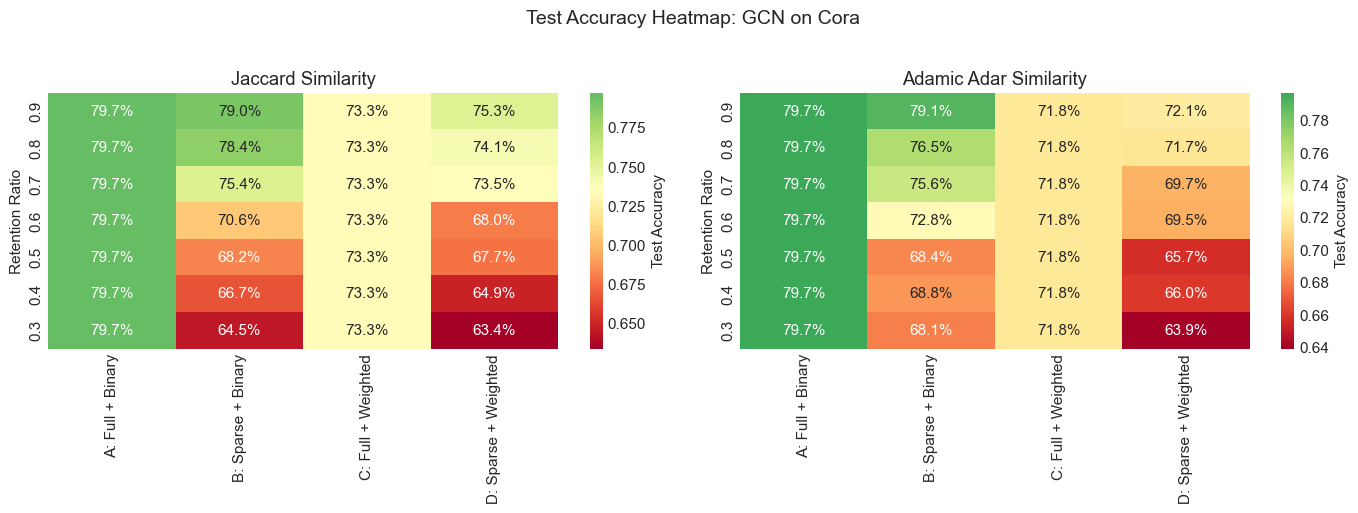

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, metric in enumerate(["Jaccard", "Adamic Adar"]):
    metric_df = df[df["Metric"] == metric]
    pivot = metric_df.pivot(index="Retention", columns="Scenario", values="Accuracy")
    pivot = pivot.sort_index(ascending=False)

    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1%",
        cmap="RdYlGn",
        center=pivot.values.mean(),
        ax=axes[idx],
        cbar_kws={"label": "Test Accuracy"},
    )
    axes[idx].set_title(f"{metric} Similarity")
    axes[idx].set_xlabel("")
    axes[idx].set_ylabel("Retention Ratio")

plt.suptitle("Test Accuracy Heatmap: GCN on Cora", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Effect Decomposition

In [8]:
def compute_effects(df_subset):
    """Compute main effects and interaction from ablation results."""
    a = df_subset[df_subset["Scenario"] == "A: Full + Binary"]["Accuracy"].values[0]
    b = df_subset[df_subset["Scenario"] == "B: Sparse + Binary"]["Accuracy"].values[0]
    c = df_subset[df_subset["Scenario"] == "C: Full + Weighted"]["Accuracy"].values[0]
    d = df_subset[df_subset["Scenario"] == "D: Sparse + Weighted"]["Accuracy"].values[0]

    return {
        "Baseline (A)": a,
        "Structure Effect (B-A)": b - a,
        "Weighting Effect (C-A)": c - a,
        "Combined Effect (D-A)": d - a,
        "Interaction (D-B-C+A)": d - b - c + a,
    }


effect_rows = []
for metric in df["Metric"].unique():
    for retention in df["Retention"].unique():
        subset = df[(df["Metric"] == metric) & (df["Retention"] == retention)]
        effects = compute_effects(subset)
        for effect_name, value in effects.items():
            effect_rows.append({
                "Metric": metric,
                "Retention": retention,
                "Effect": effect_name,
                "Value": value,
            })

effect_df = pd.DataFrame(effect_rows)
effect_df.head(10)

,Metric,Retention,Effect,Value
0,Jaccard,0.9,Baseline (A),0.797
1,Jaccard,0.9,Structure Effect (B-A),-0.007
2,Jaccard,0.9,Weighting Effect (C-A),-0.064
3,Jaccard,0.9,Combined Effect (D-A),-0.044
4,Jaccard,0.9,Interaction (D-B-C+A),0.027
5,Jaccard,0.8,Baseline (A),0.797
6,Jaccard,0.8,Structure Effect (B-A),-0.013
7,Jaccard,0.8,Weighting Effect (C-A),-0.064
8,Jaccard,0.8,Combined Effect (D-A),-0.056
9,Jaccard,0.8,Interaction (D-B-C+A),0.021


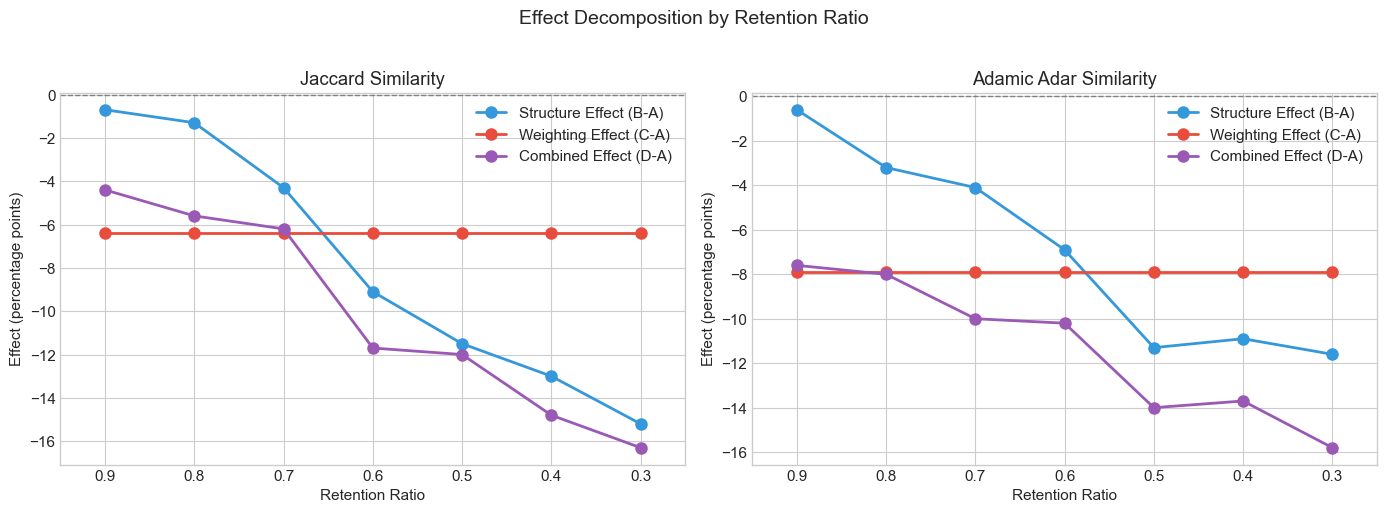

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

effects_to_plot = ["Structure Effect (B-A)", "Weighting Effect (C-A)", "Combined Effect (D-A)"]
colors = ["#3498db", "#e74c3c", "#9b59b6"]

for idx, metric in enumerate(["Jaccard", "Adamic Adar"]):
    metric_effect_df = effect_df[(effect_df["Metric"] == metric) & (effect_df["Effect"].isin(effects_to_plot))]

    for i, effect in enumerate(effects_to_plot):
        effect_data = metric_effect_df[metric_effect_df["Effect"] == effect]
        axes[idx].plot(
            effect_data["Retention"],
            effect_data["Value"] * 100,
            marker="o",
            linewidth=2,
            markersize=8,
            color=colors[i],
            label=effect,
        )

    axes[idx].axhline(0, color="gray", linestyle="--", linewidth=1)
    axes[idx].set_xlabel("Retention Ratio")
    axes[idx].set_ylabel("Effect (percentage points)")
    axes[idx].set_title(f"{metric} Similarity")
    axes[idx].legend()
    axes[idx].set_xlim(0.25, 0.95)
    axes[idx].invert_xaxis()

plt.suptitle("Effect Decomposition by Retention Ratio", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Scenario Comparison Line Plot

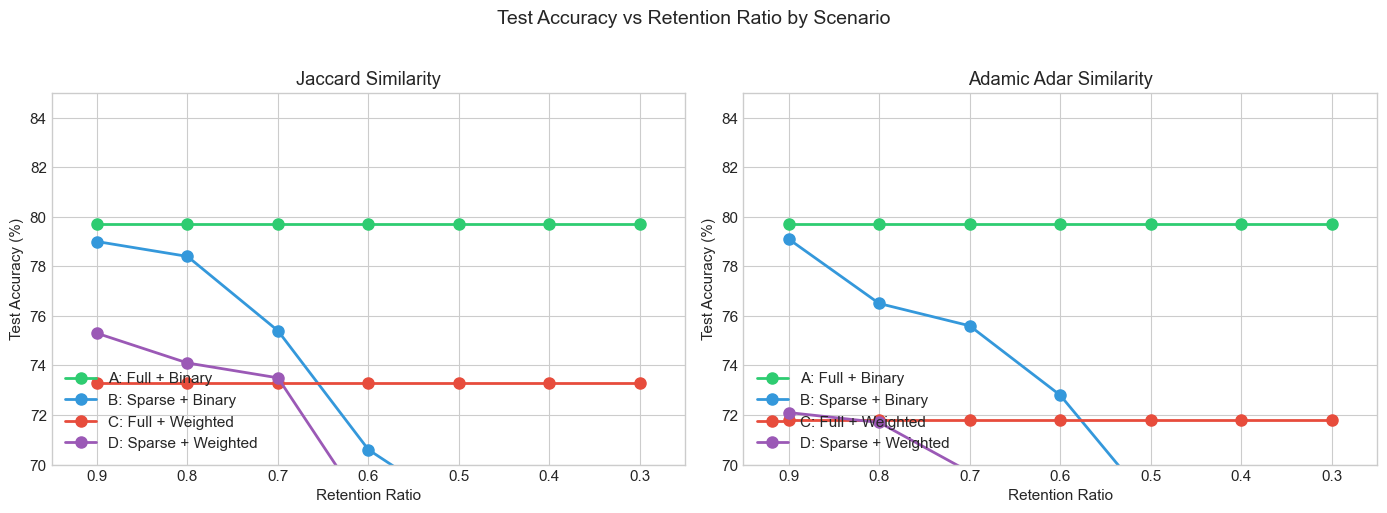

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scenario_colors = {
    "A: Full + Binary": "#2ecc71",
    "B: Sparse + Binary": "#3498db",
    "C: Full + Weighted": "#e74c3c",
    "D: Sparse + Weighted": "#9b59b6",
}

for idx, metric in enumerate(["Jaccard", "Adamic Adar"]):
    metric_df = df[df["Metric"] == metric]

    for scenario, color in scenario_colors.items():
        scenario_data = metric_df[metric_df["Scenario"] == scenario]
        axes[idx].plot(
            scenario_data["Retention"],
            scenario_data["Accuracy"] * 100,
            marker="o",
            linewidth=2,
            markersize=8,
            color=color,
            label=scenario,
        )

    axes[idx].set_xlabel("Retention Ratio")
    axes[idx].set_ylabel("Test Accuracy (%)")
    axes[idx].set_title(f"{metric} Similarity")
    axes[idx].legend(loc="lower left")
    axes[idx].set_xlim(0.25, 0.95)
    axes[idx].invert_xaxis()
    axes[idx].set_ylim(70, 85)

plt.suptitle("Test Accuracy vs Retention Ratio by Scenario", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Summary Statistics Table

In [11]:
summary = df.groupby(["Metric", "Scenario"]).agg({
    "Accuracy": ["mean", "std", "min", "max"],
    "Epochs": "mean",
}).round(4)

summary.columns = ["Mean Acc", "Std Acc", "Min Acc", "Max Acc", "Avg Epochs"]
summary

Mean Acc  Std Acc  Min Acc  Max Acc  \
Metric      Scenario                                                    
Adamic Adar A: Full + Binary        0.7970   0.0000    0.797    0.797   
            B: Sparse + Binary      0.7276   0.0445    0.681    0.791   
            C: Full + Weighted      0.7180   0.0000    0.718    0.718   
            D: Sparse + Weighted    0.6837   0.0318    0.639    0.721   
Jaccard     A: Full + Binary        0.7970   0.0000    0.797    0.797   
            B: Sparse + Binary      0.7183   0.0580    0.645    0.790   
            C: Full + Weighted      0.7330   0.0000    0.733    0.733   
            D: Sparse + Weighted    0.6956   0.0474    0.634    0.753   

                                  Avg Epochs  
Metric      Scenario                          
Adamic Adar A: Full + Binary         29.0000  
            B: Sparse + Binary       30.8571  
            C: Full + Weighted       32.0000  
            D: Sparse + Weighted     31.7143  
Jaccard     A: Full + Binary         29.0000  
            B: Sparse + Binary       31.2857  
            C: Full + Weighted       31.0000  
            D: Sparse + Weighted     32.5714

## 7. Best Configuration per Scenario

In [12]:
best_configs = df.loc[df.groupby(["Metric", "Scenario"])["Accuracy"].idxmax()]
best_configs[["Metric", "Scenario", "Retention", "Accuracy", "Epochs"]]

,Metric,Scenario,Retention,Accuracy,Epochs
28,Adamic Adar,A: Full + Binary,0.9,0.797,29
29,Adamic Adar,B: Sparse + Binary,0.9,0.791,31
30,Adamic Adar,C: Full + Weighted,0.9,0.718,32
31,Adamic Adar,D: Sparse + Weighted,0.9,0.721,30
0,Jaccard,A: Full + Binary,0.9,0.797,29
1,Jaccard,B: Sparse + Binary,0.9,0.790,28
2,Jaccard,C: Full + Weighted,0.9,0.733,31
3,Jaccard,D: Sparse + Weighted,0.9,0.753,34


## 8. Export Results

In [13]:
output_dir = Path("../results")
output_dir.mkdir(exist_ok=True)

df.to_csv(output_dir / "ablation_results.csv", index=False)
effect_df.to_csv(output_dir / "effect_decomposition.csv", index=False)
summary.to_csv(output_dir / "summary_statistics.csv")

print(f"Results exported to {output_dir.resolve()}")

Results exported to /Users/ilias/Documents/GitHub/gnn-sparsification-research/notebooks/results


## 9. Summary

This notebook provided:
- Comprehensive ablation study across multiple retention ratios and metrics
- Heatmap visualization for quick comparison
- Effect decomposition analysis (structure, weighting, interaction)
- Line plots showing trends across retention ratios
- Summary statistics and exportable CSV files

**Key Findings:**
1. The effect of sparsification varies with retention ratio
2. Weighting and sparsification may have synergistic or antagonistic interactions
3. Optimal retention ratio depends on the similarity metric used

**For publication:**
- Use the heatmaps for overview figures
- Use effect decomposition plots for detailed analysis
- Export CSV files for statistical testing in R or other tools